# > **ODE:**
$$\frac{d^2 x}{d t^2}+\mu\frac{d x}{d t}+kx=0 $$

,where $ \mu=2m\delta, k = m\omega^2$

Condition: $x(0)=1, \frac{d x}{d t}(0)=0, m=1$


# > **Solution**
$$x(t)=2A e^{-\delta t} cos(\phi + \omega t)$$

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

USE_GPU = True
dtype = torch.float64

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [94]:
# To make gif files
files = []
if not(os.path.isdir('./plots')):
    os.system("mkdir plots")
if not(os.path.isdir('./result')):
    os.system("mkdir result")

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x, y, x_data, y_data, yh, epoch):
    "Pretty plot training results"
    plt.figure(figsize=(8,5))
    plt.plot(x, y, color="gray", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, marker="s", color="r", alpha=0.4, label='Training data with noise')
    plt.legend(loc='lower right')
    plt.xlabel("Time", size=20)
    plt.ylabel("Displacement", size=20)
    plt.xlim(-0.05, 1.05)
    plt.xlim(-0., 1.)
    plt.ylim(-1.1, 1.1)
    plt.text(.6,0.8,"Training step: %i"%(epoch),fontsize="xx-large",color="k")
    file = "plots/pinn_%.8i.png"%(epoch)
    files.append(file)  
    plt.savefig(file, dpi=300)

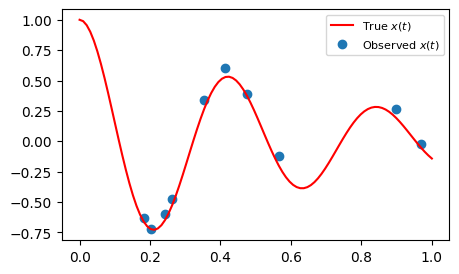

In [110]:
# https://beltoforion.de/en/harmonic_oscillator/
def oscillator(delta, omega0, t):
    assert delta < omega0
    omega   = np.sqrt(omega0**2 - delta**2)
    phi     = np.arctan(-delta/omega)
    A       = 1/(2*np.cos(phi))
    return torch.exp(-delta * t)*2*A*torch.cos(phi+omega*t)

N_grid, delta, omega0 =100, 1.5, 15
mu_real, k_real = 2*delta, omega0**2        ## mass = 1

t_grid  = torch.linspace(0, 1, N_grid).view(-1,1)
x_grid  = oscillator(delta, omega0, t_grid).view(-1,1)

N_obs = 10
idx     = np.random.choice(np.arange(len(t_grid)), replace=0, size=N_obs)
t_obs   = t_grid[idx]
x_obs   = x_grid[idx]

NOISE = True
if NOISE:
    x_obs += torch.rand(x_obs.size())*0.1

figure = plt.figure(figsize=(5,3))
plt.plot(t_grid, x_grid, color='r', label='True $x(t)$')
plt.scatter(t_obs, x_obs, marker='o',label='Observed $x(t)$')
plt.legend(fontsize=8)

t_obs, x_obs             = t_obs.to(device).requires_grad_(True), x_obs.to(device)
t_grid, x_grid           = t_grid.to(device).requires_grad_(True), x_grid.to(device)
t_init, x_init, dx_init  = torch.zeros([1,1]).to(device).requires_grad_(True), torch.ones([1,1]).to(device), torch.zeros([1,1]).to(device)

k   = torch.ones(1).to(device).requires_grad_(True)
mu  = torch.ones(1).to(device).requires_grad_(True)

In [111]:
model = nn.Sequential(nn.Linear(1,64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 1))
model = model.to(device)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': k, 'lr':0.01}, {'params': mu, 'lr':0.5}], lr=0.001)

scheduler = None
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20000], gamma=2)

In [78]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True, grad_outputs=torch.ones(y.size()).to(device))[0]

EPOCH :   1000/ 50000 | MSE_real : 0.0314321 | MSE_obs : 0.0081874 | mu : 0.204 | k : 13.587
EPOCH :   2000/ 50000 | MSE_real : 0.0270061 | MSE_obs : 0.0054017 | mu : 0.372 | k : 27.050
EPOCH :   3000/ 50000 | MSE_real : 0.0304599 | MSE_obs : 0.0048541 | mu : 0.548 | k : 40.856
EPOCH :   4000/ 50000 | MSE_real : 0.0457090 | MSE_obs : 0.0021732 | mu : 0.669 | k : 55.054
EPOCH :   5000/ 50000 | MSE_real : 0.0545040 | MSE_obs : 0.0003482 | mu : 0.617 | k : 69.204
EPOCH :   6000/ 50000 | MSE_real : 0.0380398 | MSE_obs : 0.0013026 | mu : 0.779 | k : 83.013
EPOCH :   7000/ 50000 | MSE_real : 0.0258158 | MSE_obs : 0.0000686 | mu : 0.869 | k : 96.864
EPOCH :   8000/ 50000 | MSE_real : 0.0102877 | MSE_obs : 0.0000512 | mu : 1.119 | k : 110.591
EPOCH :   9000/ 50000 | MSE_real : 0.0076075 | MSE_obs : 0.0000910 | mu : 1.304 | k : 124.282
EPOCH :  10000/ 50000 | MSE_real : 0.0045470 | MSE_obs : 0.0001391 | mu : 1.539 | k : 137.837
EPOCH :  11000/ 50000 | MSE_real : 0.0029228 | MSE_obs : 0.0001990 

/tmp/ipykernel_57176/3129994241.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,5))


EPOCH :  22000/ 50000 | MSE_real : 0.0006212 | MSE_obs : 0.0017108 | mu : 2.938 | k : 221.277
EPOCH :  23000/ 50000 | MSE_real : 0.0002709 | MSE_obs : 0.0023313 | mu : 2.848 | k : 221.145
EPOCH :  24000/ 50000 | MSE_real : 0.0002503 | MSE_obs : 0.0025762 | mu : 2.882 | k : 221.051
EPOCH :  25000/ 50000 | MSE_real : 0.0003026 | MSE_obs : 0.0026748 | mu : 2.881 | k : 221.014
EPOCH :  26000/ 50000 | MSE_real : 0.0002561 | MSE_obs : 0.0018517 | mu : 2.903 | k : 221.034
EPOCH :  27000/ 50000 | MSE_real : 0.0002536 | MSE_obs : 0.0028681 | mu : 2.889 | k : 221.062
EPOCH :  28000/ 50000 | MSE_real : 0.0002495 | MSE_obs : 0.0030545 | mu : 2.872 | k : 221.125
EPOCH :  29000/ 50000 | MSE_real : 0.0002542 | MSE_obs : 0.0025509 | mu : 2.896 | k : 221.160
EPOCH :  30000/ 50000 | MSE_real : 0.0002554 | MSE_obs : 0.0026999 | mu : 2.896 | k : 221.236
EPOCH :  31000/ 50000 | MSE_real : 0.0001913 | MSE_obs : 0.0026122 | mu : 2.904 | k : 221.280
EPOCH :  32000/ 50000 | MSE_real : 0.0002679 | MSE_obs : 0.0

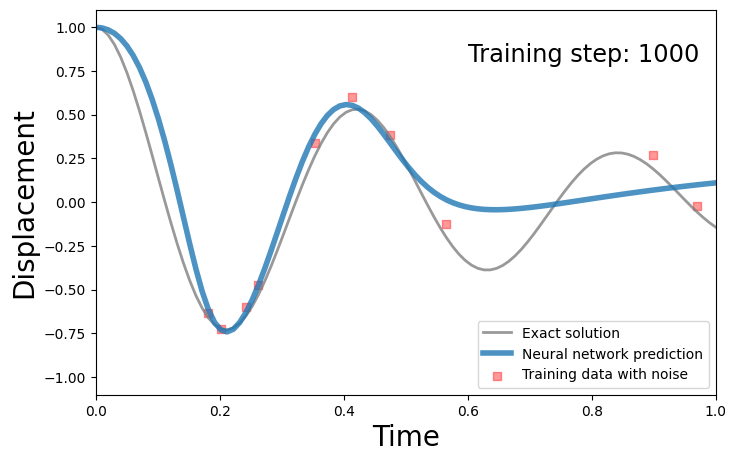

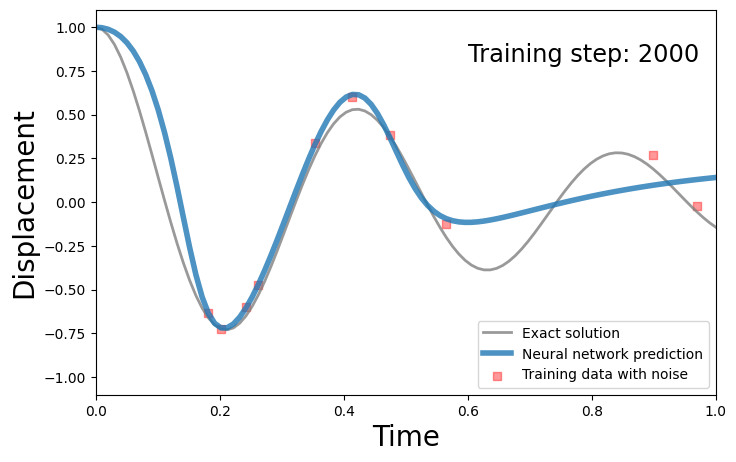

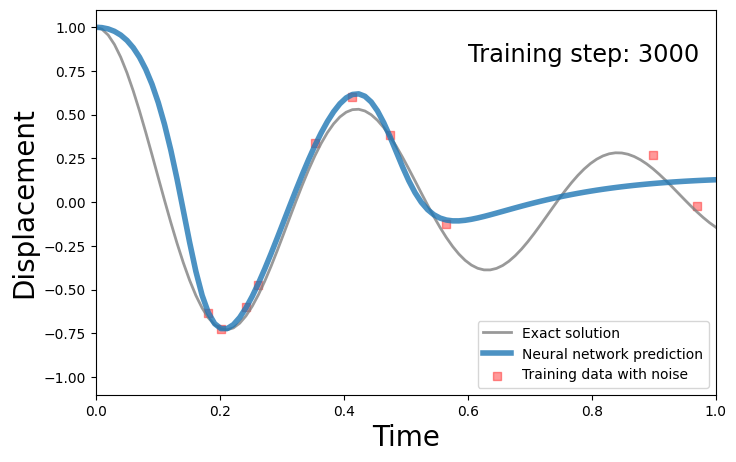

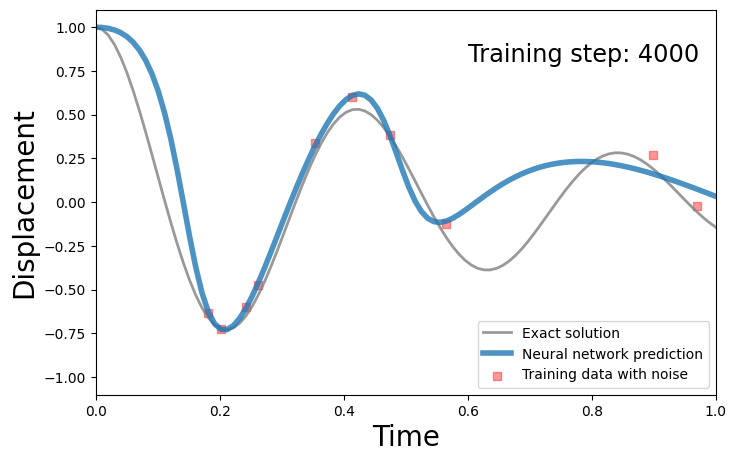

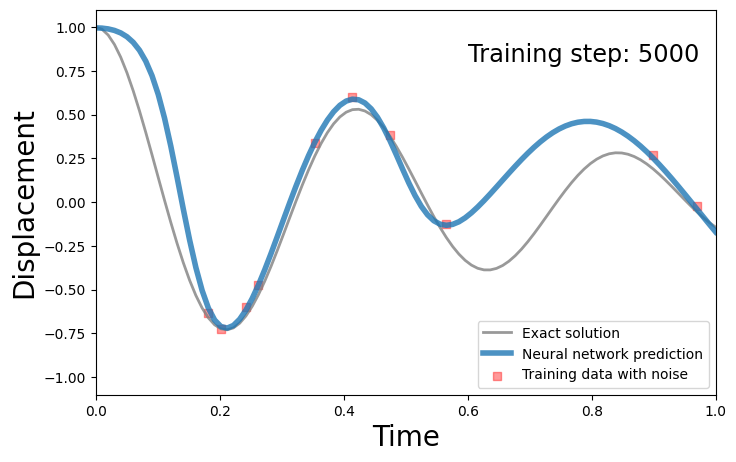

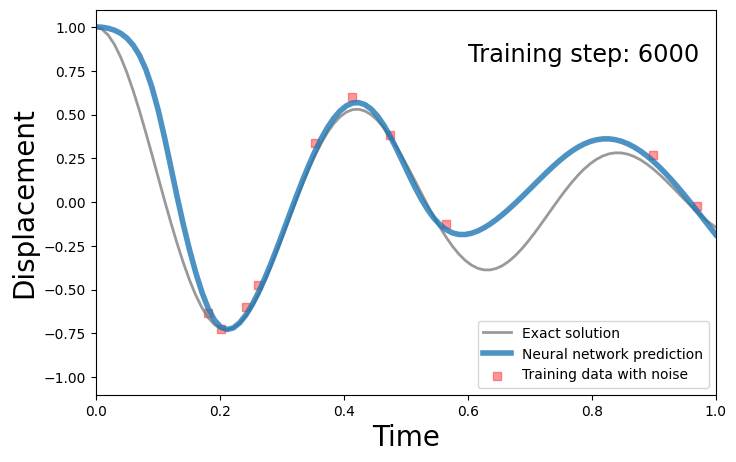

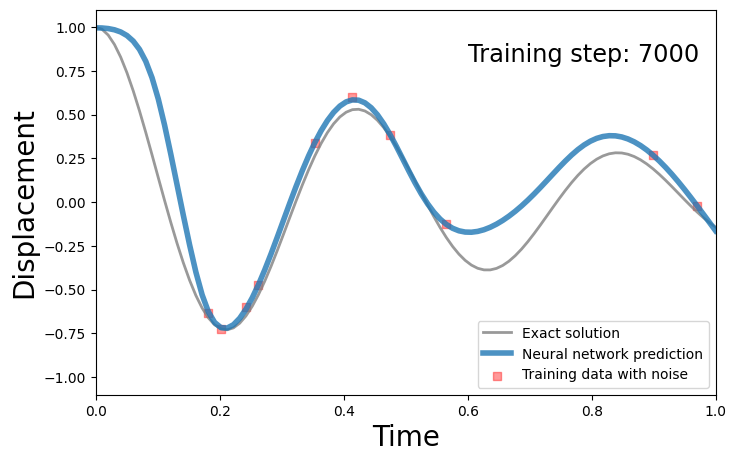

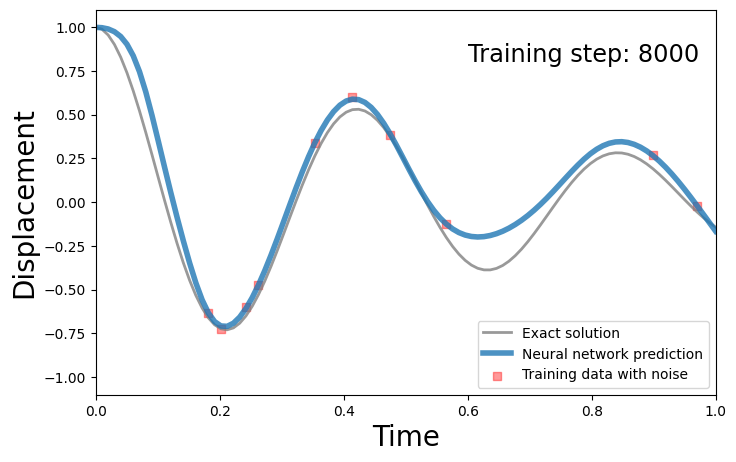

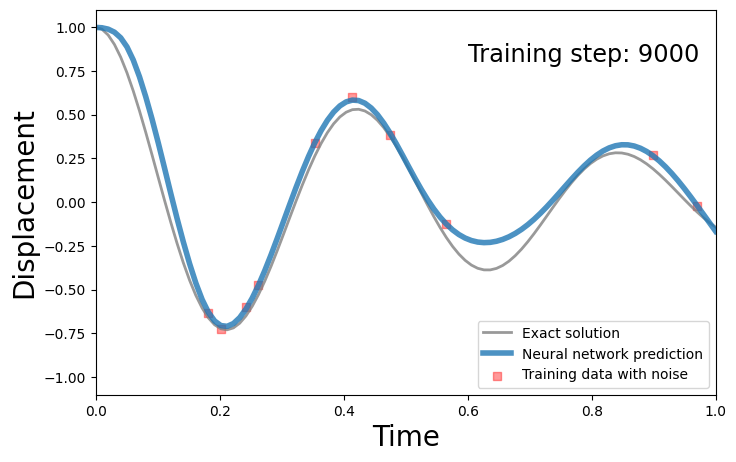

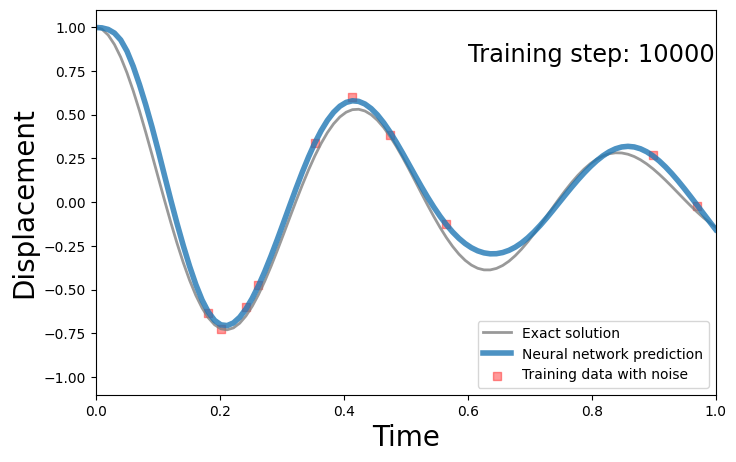

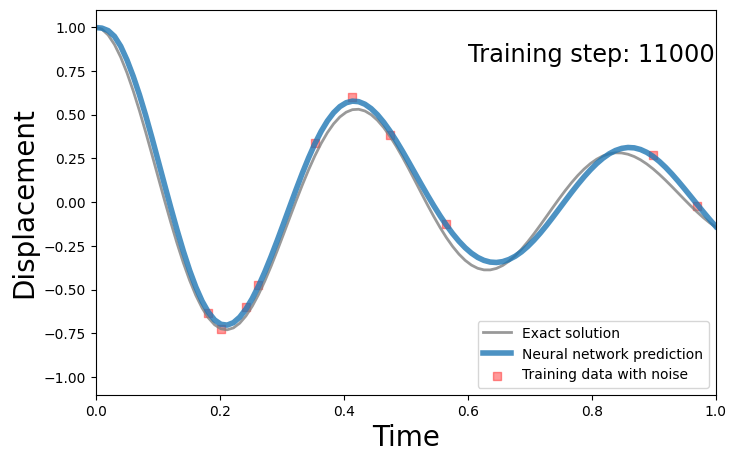

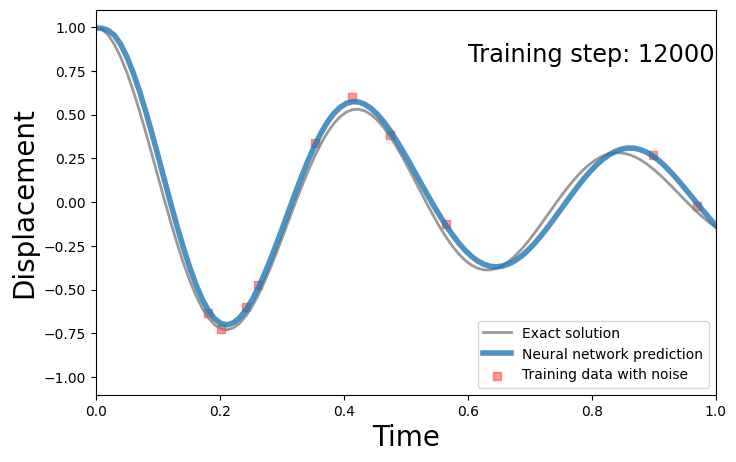

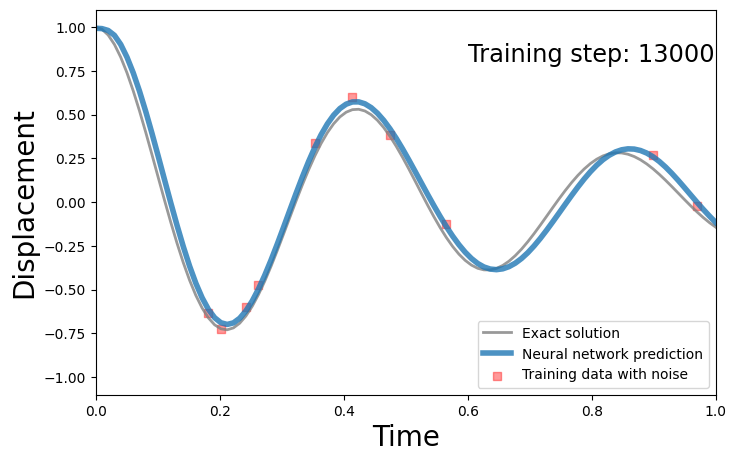

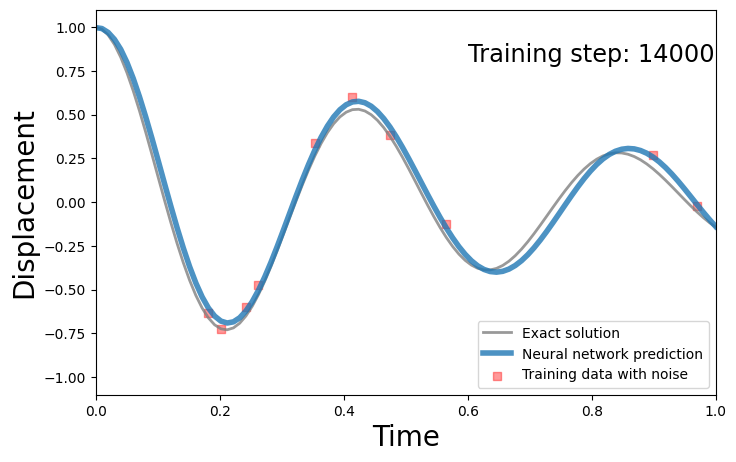

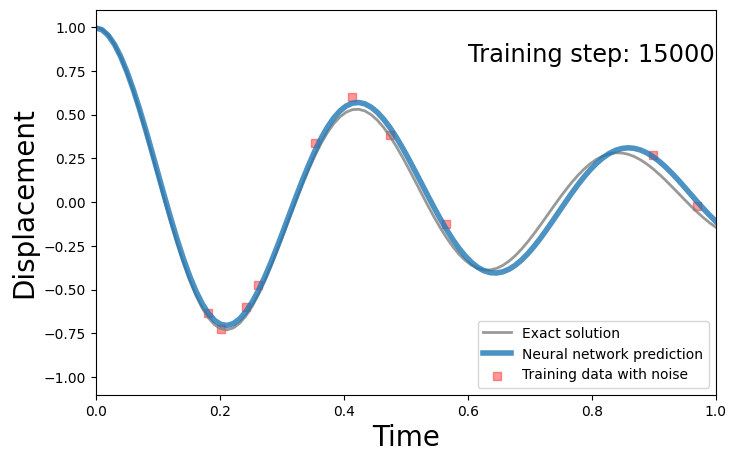

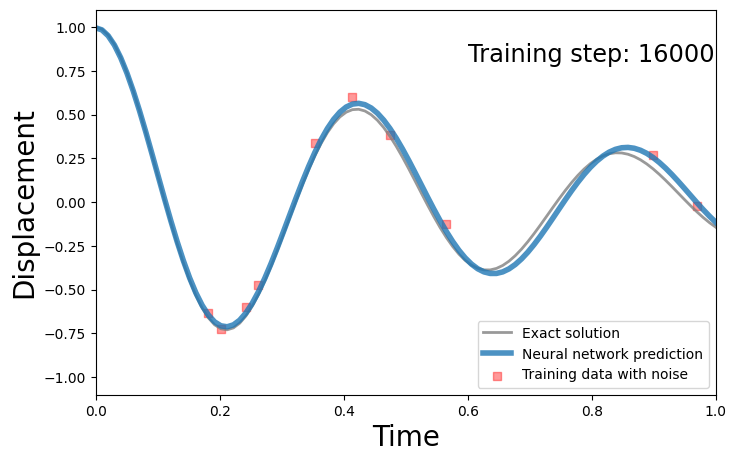

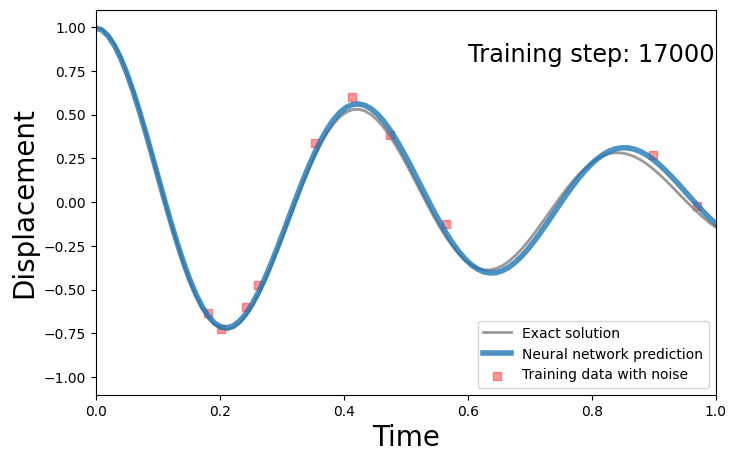

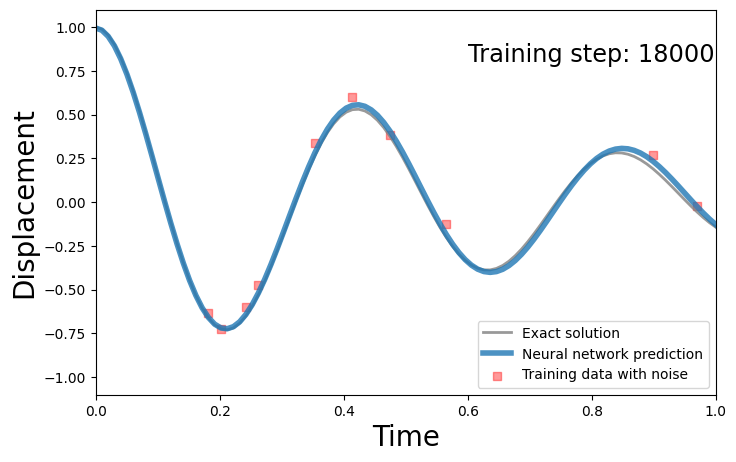

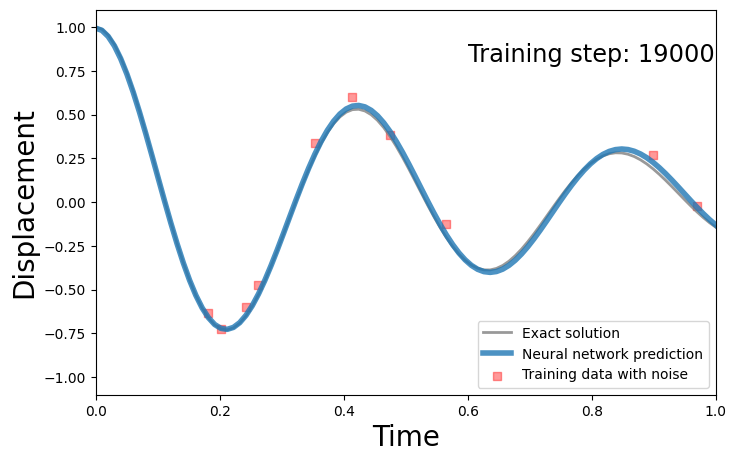

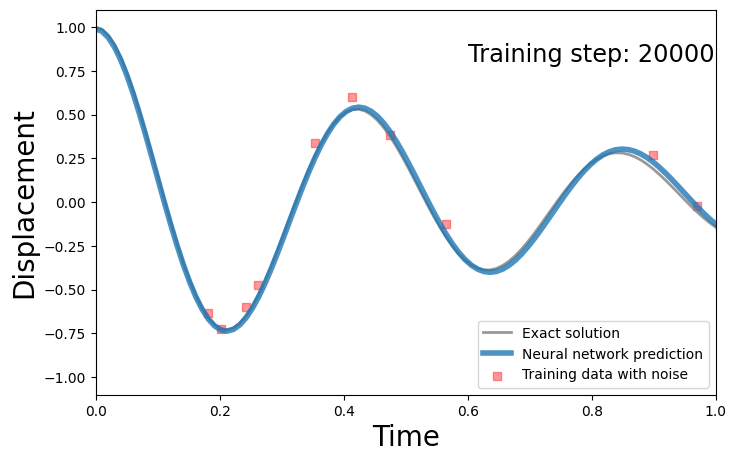

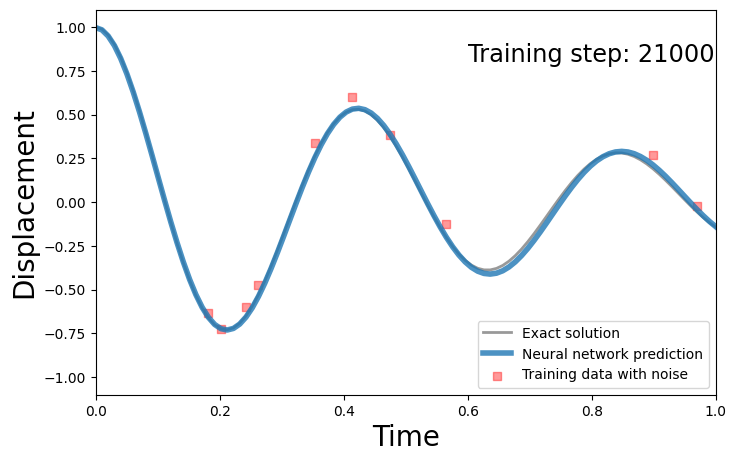

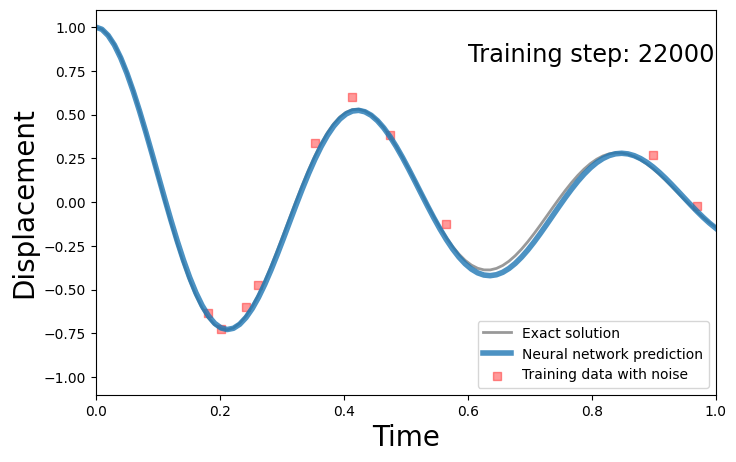

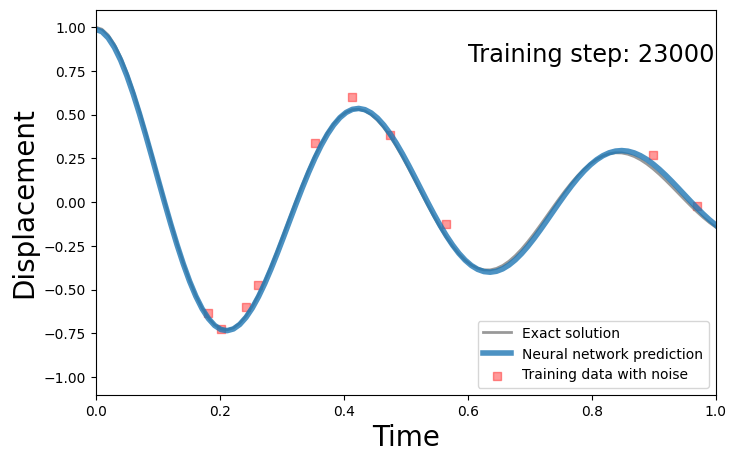

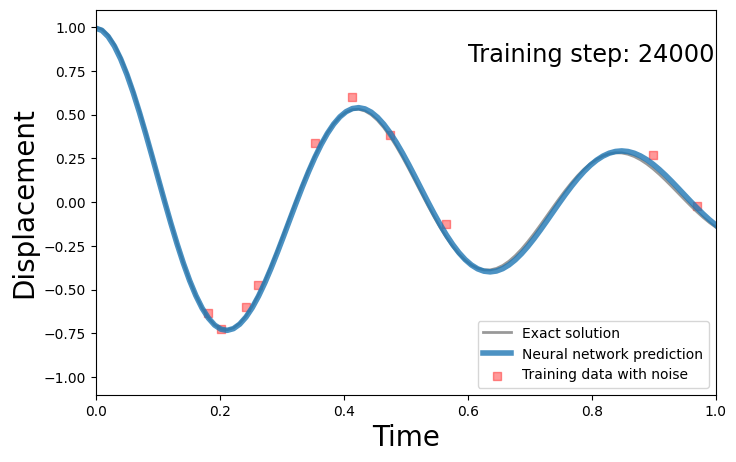

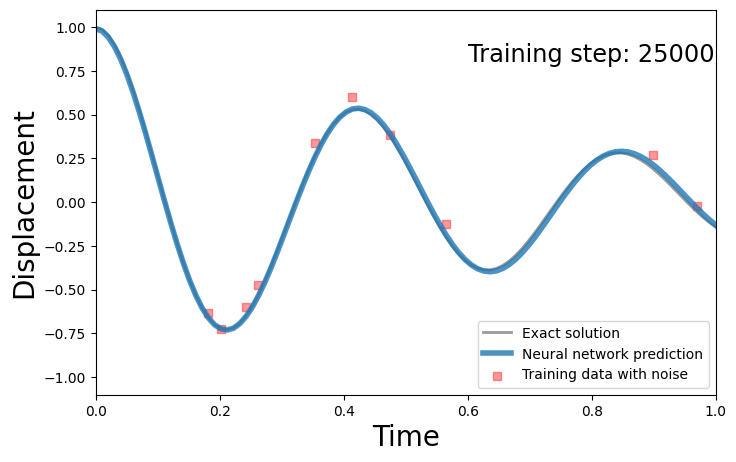

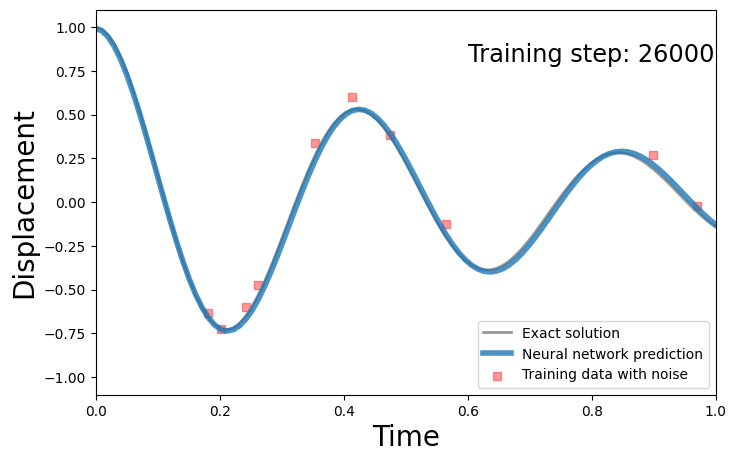

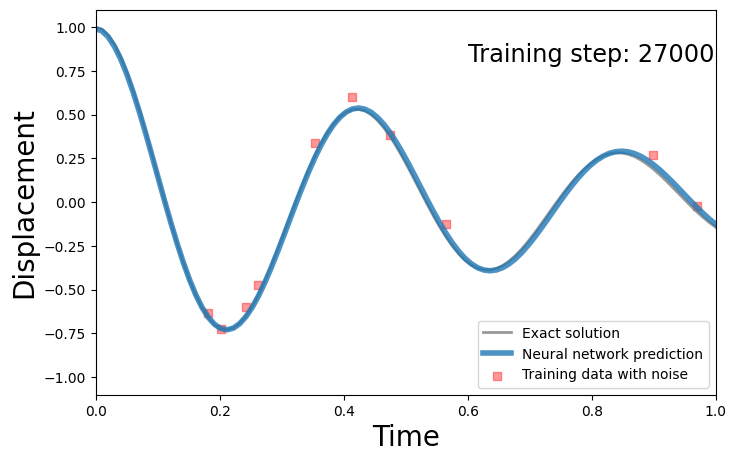

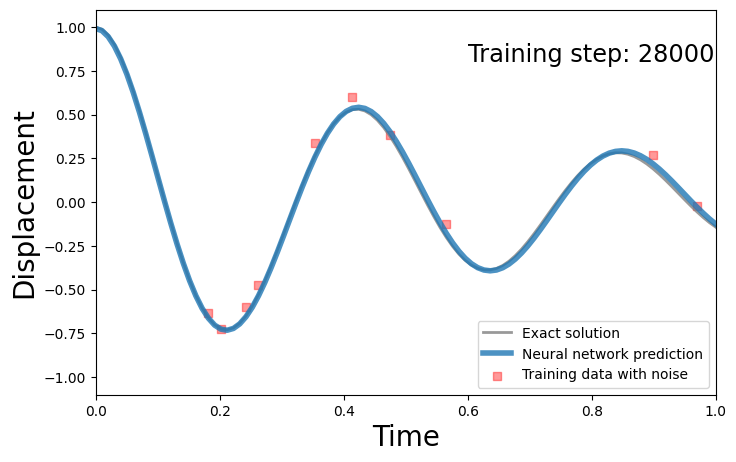

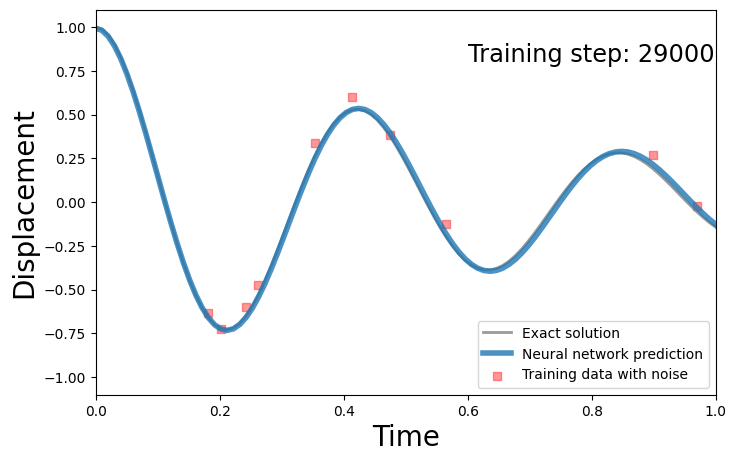

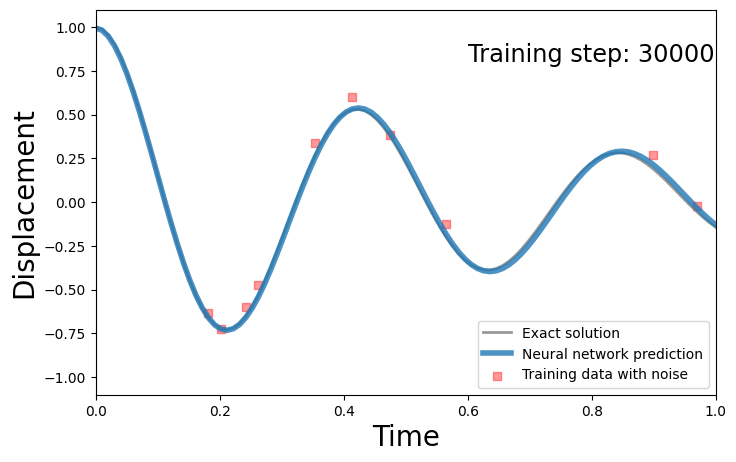

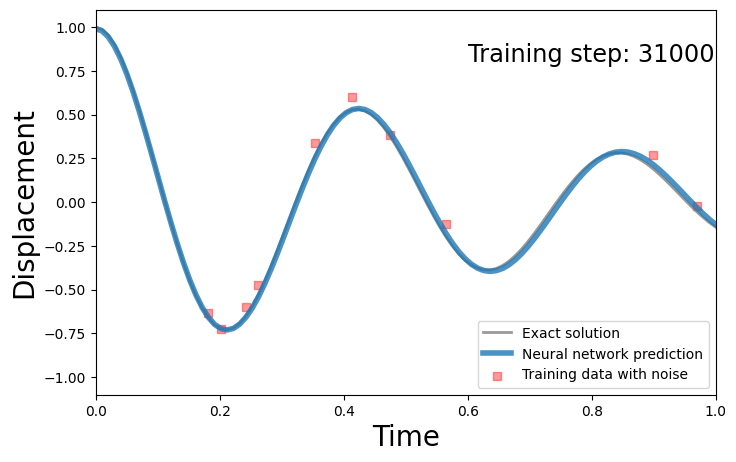

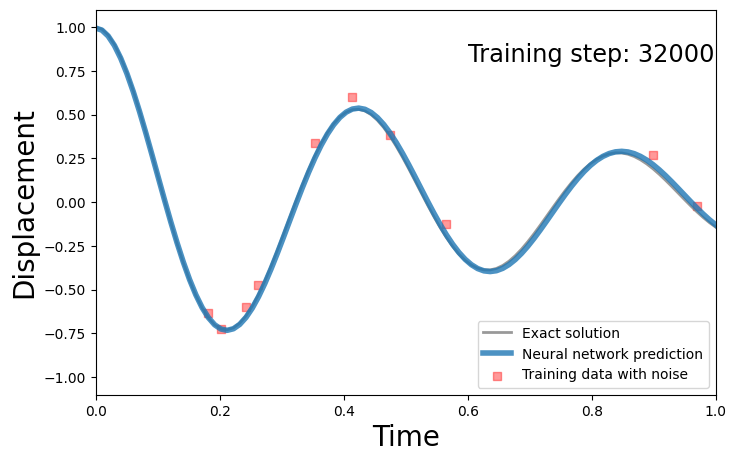

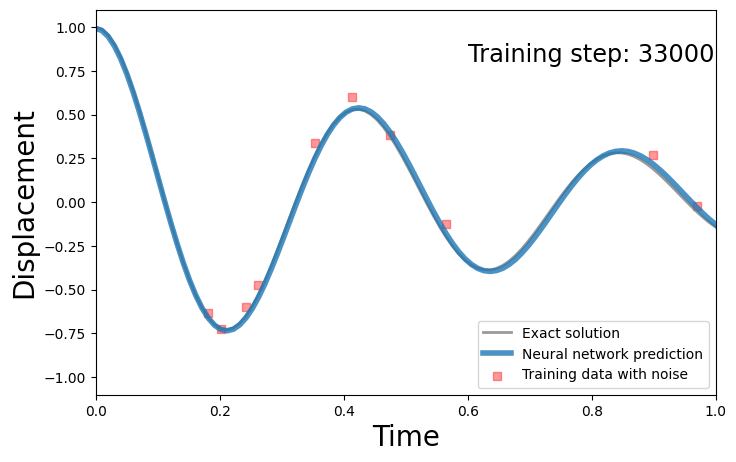

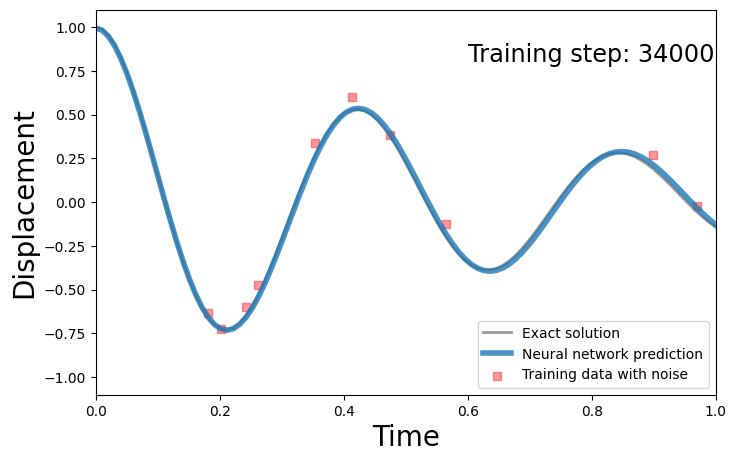

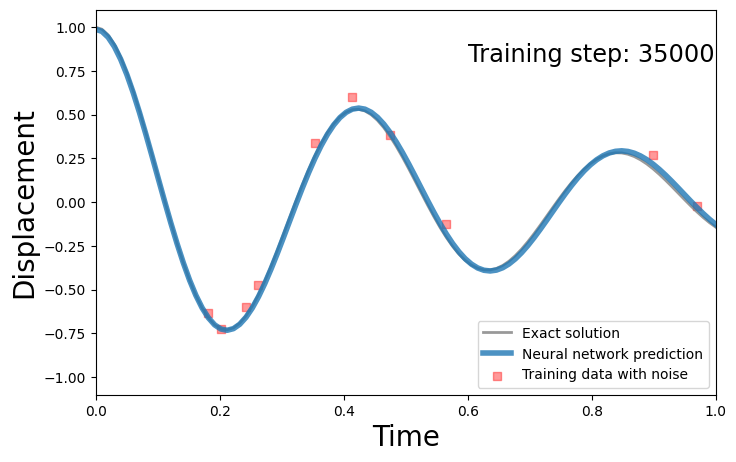

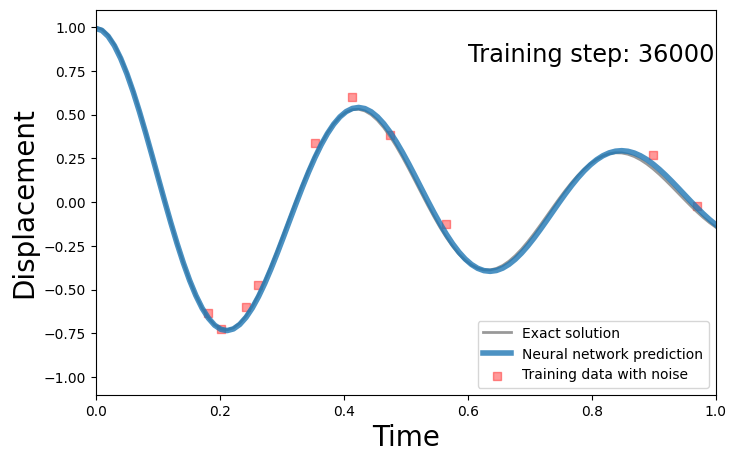

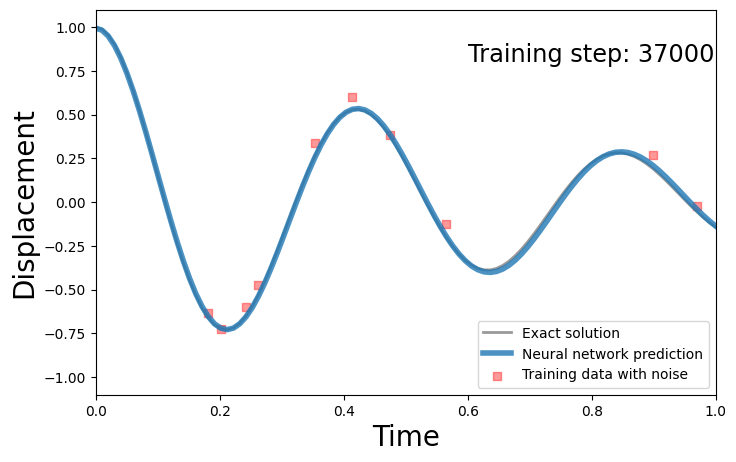

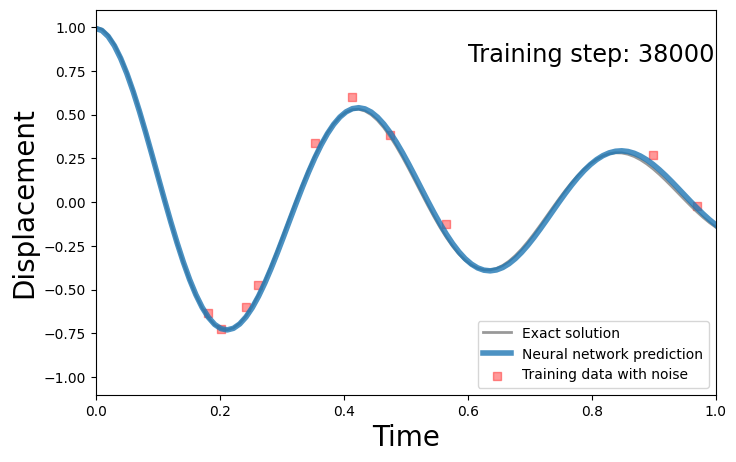

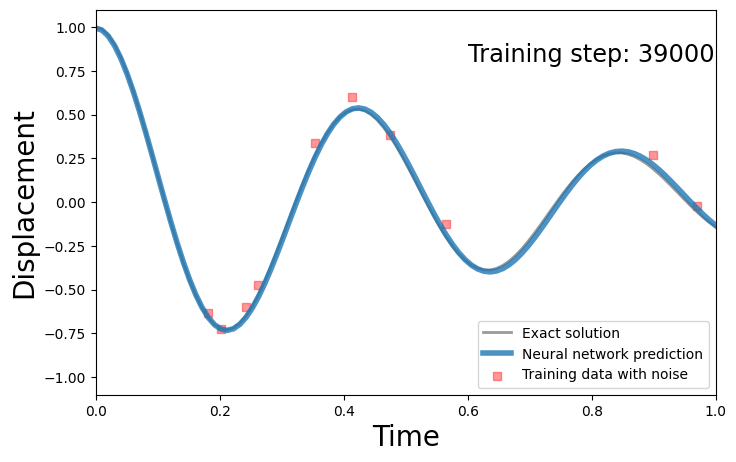

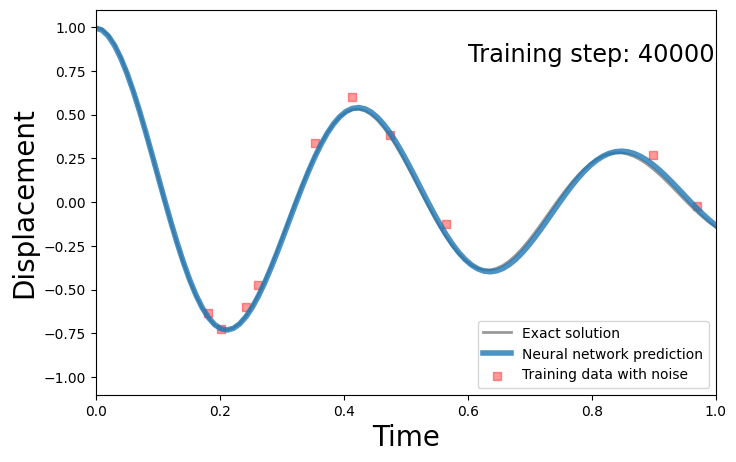

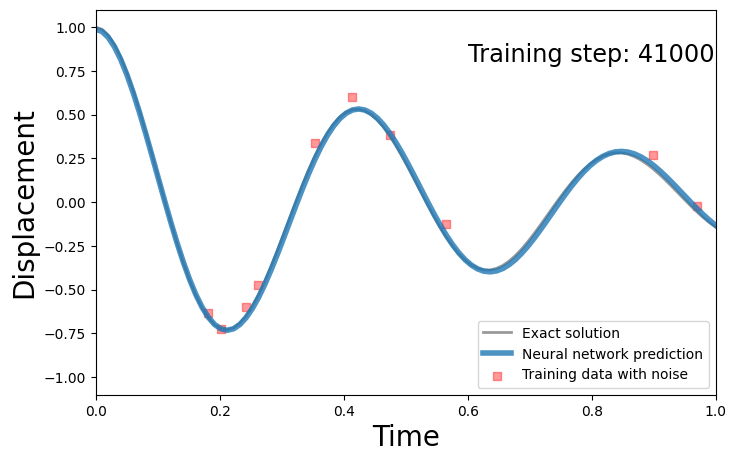

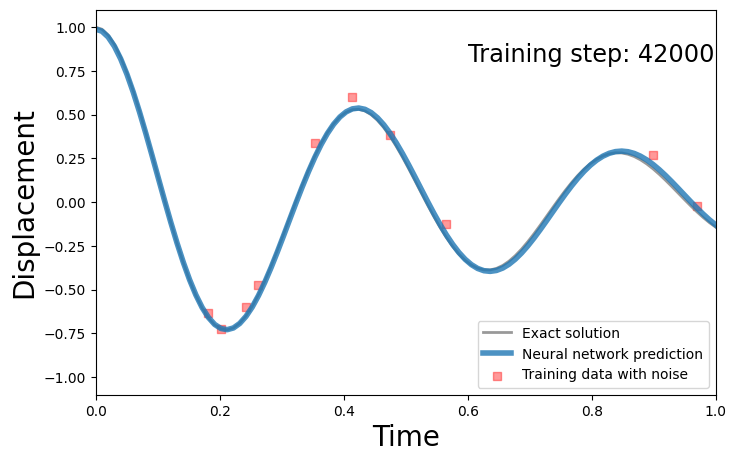

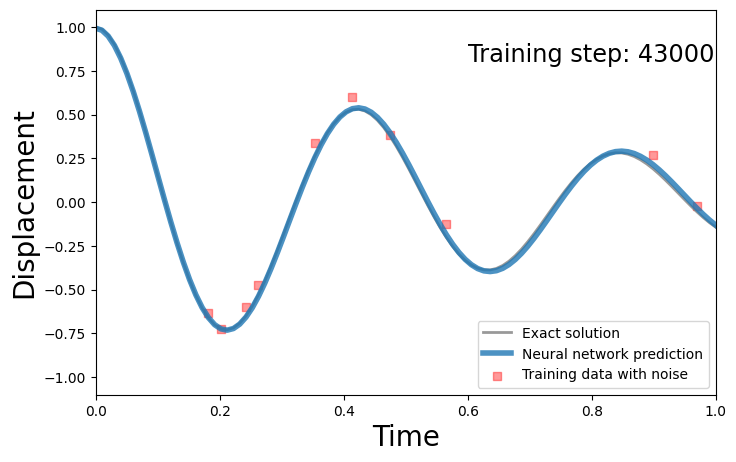

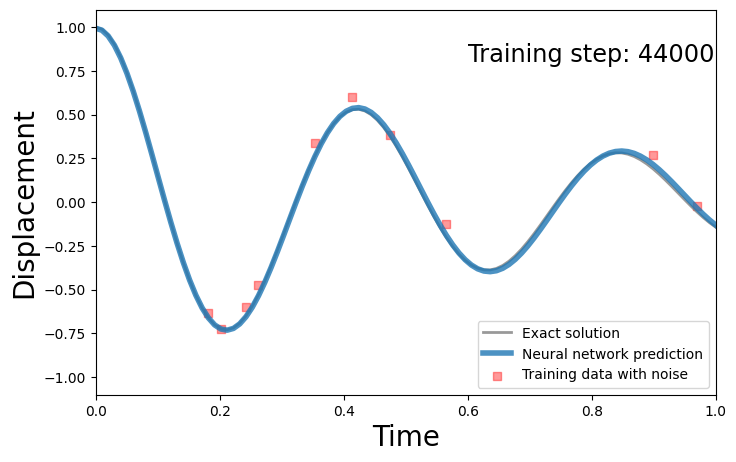

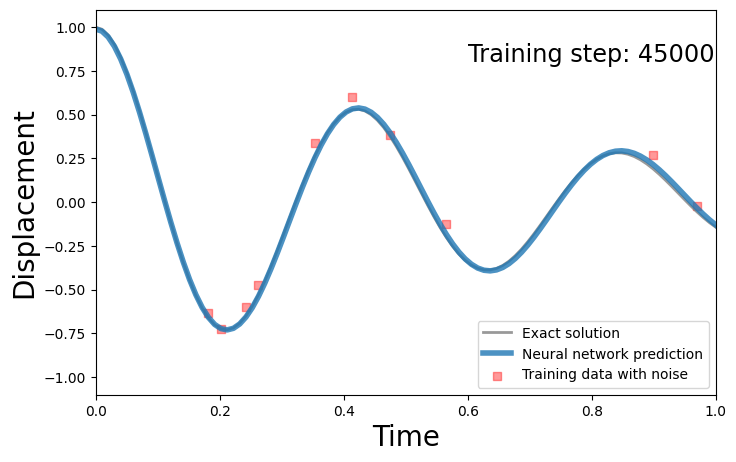

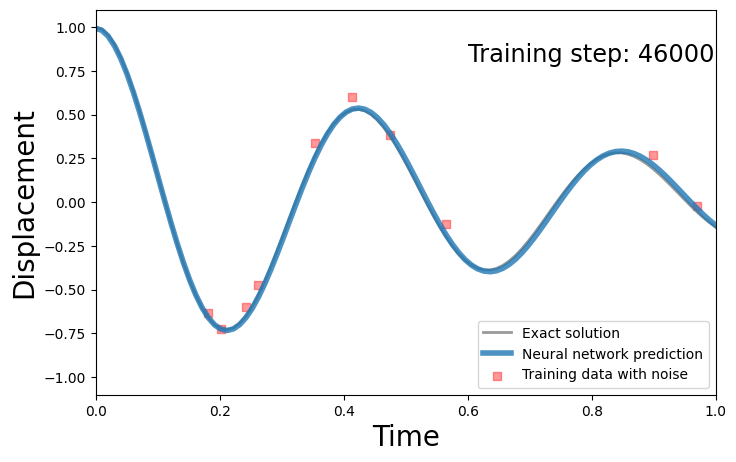

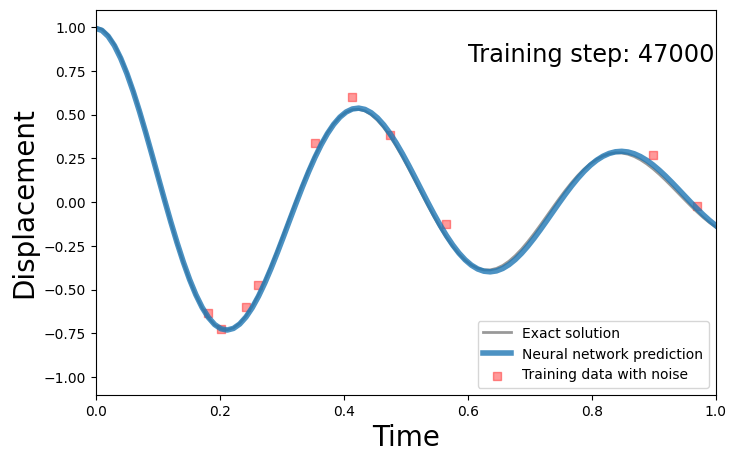

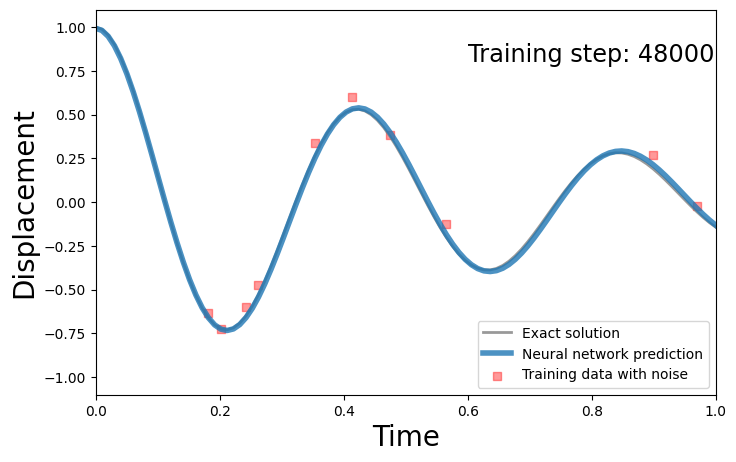

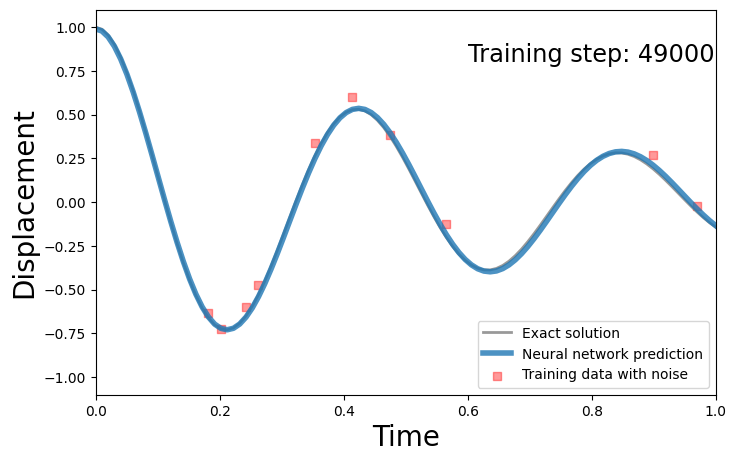

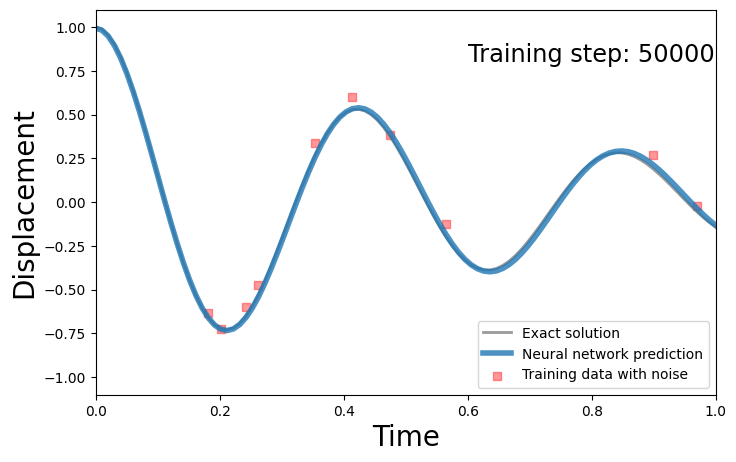

In [112]:
history_loss, history_k, history_mu = [], [], []
history_MSE_real, history_MSE_obs = [], []

gif = True

best_model=None
best_k, best_mu, best_loss = 0, 0, 100

# Train
model.train()

EPOCHS = 50000
weights = torch.sigmoid(torch.linspace(-15, 15, EPOCHS))*0.01
weights = weights.to(device)

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()

    output      = model(t_grid)                         # x(t)
    output_init = model(t_init)                         # x(t_init)
    output_obs  = model(t_obs)                          # x(t_obs)

    doutput     = derivative(output, t_grid)            # dx/dt(t)
    d2output    = derivative(doutput, t_grid)           # dx/dt(t)
    doutput_init= derivative(output_init, t_init)       # dx/dt(t_init)

    # # For general case, use below.
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init) / 2                  # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs) / N_obs                                                # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput)) / N_grid     # Loss for ODE

    ## Original version. Not good for noisy case
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                      # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs)                                                        # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput))*(1.0e-4)     # Loss for ODE

    # Importance of ODS loss will be increase as epochs proceeds (For noisy case)
    loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                         # Loss for initial conditions
    loss_obs    = loss_f(output_obs, x_obs)                                                           # Loss for observed data
    loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput))*weights[i-1]   # Loss for ODE

    loss        = loss_init + loss_obs + loss_ge
    loss.backward()

    optimizer.step()
    if scheduler != None:
        scheduler.step()

    history_loss.append(loss.item())
    history_mu.append(mu.item())
    history_k.append(k.item())
    history_MSE_real.append(loss_f(x_grid, model(t_grid)).item())
    history_MSE_obs.append(loss_f(x_obs, model(t_obs)).item())

    if loss.item() < best_loss:
        best_model = model
        best_loss, best_mu, best_k = loss.item(), mu.item(), k.item()

    # if not i % 1000 :
    #     print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_obs : %8.7f | mu : %.3f | k : %.3f'\
    #           %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_obs.item(), mu.item(), k.item()))

    if not i % 1000 :
        print('EPOCH : %6d/%6d | MSE_real : %8.7f | MSE_obs : %8.7f | mu : %.3f | k : %.3f'\
              %(i, EPOCHS,  history_MSE_real[-1], history_MSE_obs[-1], mu.item(), k.item()))
      
        if gif == True:
            plot_result(t_grid.cpu().detach(), x_grid.cpu().detach(), t_obs.cpu().detach(), x_obs.cpu().detach(), output.cpu().detach(), i)

if gif == True:
    save_gif_PIL("result/pinn.gif", files, fps=5, loop=0)
    print('Save gif.')
            
print('Training Finished.')

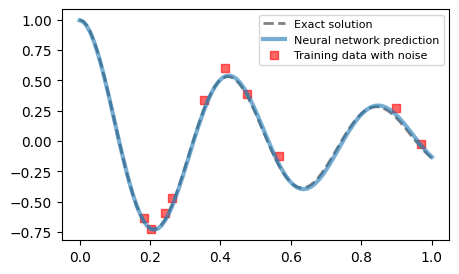

In [130]:
# View data
figure = plt.figure(figsize=(5,3))
plt.plot(t_grid.cpu().detach(), x_grid.cpu().detach(), color="gray", linewidth=2, linestyle='--', alpha=1.0, label="Exact solution")
# plt.plot(t_grid.cpu().detach(), best_model(t_grid).cpu().detach(), color='r', label='PINN $x(t)$') # For best model
plt.plot(t_grid.cpu().detach(), model(t_grid).cpu().detach(), color="tab:blue", linewidth=3, alpha=0.6, label="Neural network prediction")        # For final model
plt.scatter(t_obs.cpu().detach(), x_obs.cpu().detach(), marker="s", color="r", alpha=0.6, label='Training data with noise')
plt.legend(fontsize=8)

plt.savefig('Final prediction.png', dpi=300)

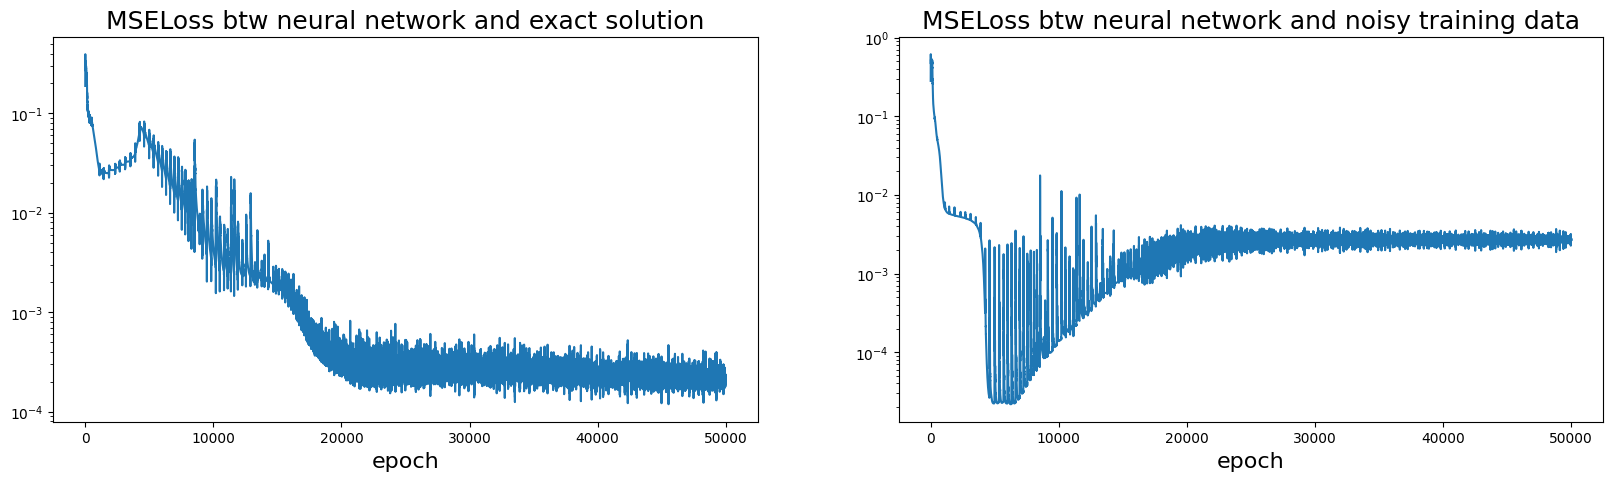

In [153]:
figure = plt.figure(figsize=(20,5))
ax1 = figure.add_subplot(1,2,1)
ax1.set_yscale('log')
ax1.plot(history_MSE_real)
ax1.set_title('MSELoss btw neural network and exact solution', fontsize= 18)
ax1.set_xlabel('epoch', fontsize= 16)

ax2 = figure.add_subplot(1,2,2)
ax2.set_yscale('log')
ax2.plot(history_MSE_obs)
ax2.set_title('MSELoss btw neural network and noisy training data', fontsize= 18)
ax2.set_xlabel('epoch', fontsize=16)

plt.savefig('MSELoss_history.png', dpi=300)

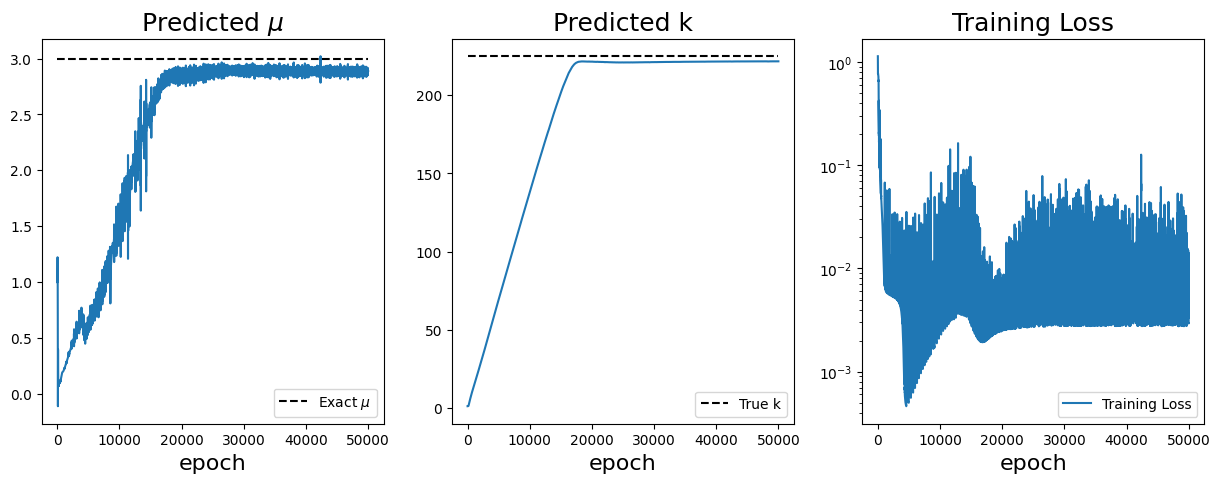

In [154]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(history_mu)
ax1.set_title('Predicted $\mu$', fontsize=18)
ax1.set_xlabel('epoch', fontsize=16)
ax1.hlines(mu_real, 0, EPOCHS, color='k',linestyle='--', label='Exact $\mu$')
# ax1.hlines(best_mu, 0, EPOCHS, color='r', label='Best $\mu$') # For best model
ax1.legend(loc='lower right')


ax2 = figure.add_subplot(1,3,2)
ax2.plot(history_k)
ax2.set_title('Predicted k', fontsize=18)
ax2.set_xlabel('epoch', fontsize=16)
ax2.hlines(k_real, 0, EPOCHS, color='k', linestyle='--', label='True k')
# ax2.hlines(best_k, 0, EPOCHS, color='r', label='Best k') # For best model
ax2.legend(loc='lower right')


ax3 = figure.add_subplot(1,3,3)
ax3.plot(history_loss, label='Training Loss')
ax3.set_yscale('log')
ax3.legend(loc='lower right')
ax3.set_title('Training Loss', fontsize=18)
ax3.set_xlabel('epoch', fontsize=16)

plt.savefig('Final results', dpi=300)